#### Import necessary libraries 

In [1]:
!pip install deepchem==2.6.1
!pip install rdkit-pypi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 608 kB 4.9 MB/s 
     |████████████████████████████████| 29.3 MB 7.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
# importing utility modules
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
 
# importing machine learning models for prediction
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier 
# importing voting classifier
from sklearn.ensemble import VotingClassifier
import deepchem as dc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from deepchem import metrics

import numpy as np
from sklearn.metrics import matthews_corrcoef
from deepchem.splits import RandomSplitter
from scipy.stats import ttest_ind


#### Read in the preprocessed BBB dataset from Adenot paper

In [3]:
bbb_df = pd.read_csv('adenot_processed.csv')

In [4]:
bbb_df.head()

,Drug,SMILES,permeable,0,1,2,3,4,5,6,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,ACEBUTOLOL,CCCC(=O)Nc1ccc(c(c1)C(C)=O)OCC(O)CNC(C)C,0,0,1,0,0,1,0,0,...,1,0,0,1,0,0,0,0,0,0
1,DACTINOMYCIN,CC(C)[C@H]1NC(=O)[C@@H](NC(=O)c2ccc(c3c2N=C2C(...,0,0,1,0,0,1,1,0,...,0,0,0,0,0,1,0,0,0,0
2,ALDOSTERONE,C[C@@]12CCC(=O)C=C2CC[C@H]2C3CC[C@H](C(=O)CO)C...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,AMILORIDE,N\C(=N)\NC(=O)c1nc(c(nc1N)N)Cl,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AMIODARONE,CCCCc1oc2ccccc2c1C(=O)c1cc(c(c(c1)[I])OCCN(CC)...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Data preprocessing

In [5]:
X = bbb_df.iloc[:,3:].copy()
y = bbb_df.iloc[:,2].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

#### Optimized Random Forest

In [6]:
# Create a Random Forest Classifier
rf_best = RandomForestClassifier(random_state=0, n_estimators = 100, criterion='gini', max_depth=20)

# Train the model using the training sets
rf_best.fit(X_train,y_train)
y_pred = rf_best.predict(X_test)

#### Optimized SVM

In [7]:
# Create a Support Vector Machine Classifier
SVM_best = SVC(C=0.1, gamma=1, kernel='linear', probability=True).fit(X_train, y_train)

# Train the model using the training sets
SVM_best.fit(X_train, y_train)
# make predictions for test data
y_pred = SVM_best.predict(X_test)

#### Optimized XGBoost

In [8]:
xg_best = XGBClassifier(
 learning_rate =0.1,
 n_estimators=1000,
 max_depth=4,
 min_child_weight=3,
 gamma=0,
 subsample=0.8,
 colsample_bytree=0.85,
 reg_alpha=1e-05,
 objective= 'binary:logistic',
 nthread=4,
 scale_pos_weight=1,)

In [9]:
xg_best.fit(X_train, y_train)
# make predictions for test data
y_pred = xg_best.predict(X_test)

### Ensemble

In [10]:
# Making the final model using voting classifier
final_model = VotingClassifier(
    estimators=[('svm', SVM_best), ('xgb', xg_best), ('rf', rf_best)], voting='soft')
 
# training all the model on the train dataset
final_model.fit(X_train, y_train)
 
# predicting the output on the test dataset
y_pred = final_model.predict(X_test)


### Random Split PCA, DR, and Result Metrics

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Random Split Metrics:
Accuracy: 0.9618473895582329
Balanced Accuracy: 0.910765306122449
ROC AUC: 0.910765306122449
Precision Score: 0.9590361445783132
Recall Score: 0.995



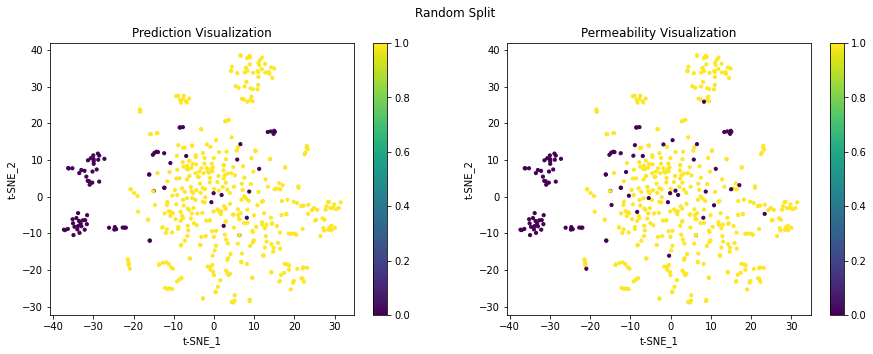

In [11]:
def plot_split(split, y_pred, y_test, t_components):
    
    fig = plt.figure(figsize=(15, 5))
    fig.suptitle('{} Split'.format(split))
    plt.subplot(1, 2, 1)
    plt.scatter(t_components[:,0], t_components[:,1], c=y_pred, s=10)
    plt.xlabel('t-SNE_1')
    plt.ylabel('t-SNE_2')
    plt.title('Prediction Visualization')
    plt.colorbar()

    plt.subplot(1, 2, 2)
    plt.scatter(t_components[:,0], t_components[:,1], c=y_test,s=10)
    plt.xlabel('t-SNE_1')
    plt.ylabel('t-SNE_2')
    plt.title('Permeability Visualization')
    plt.colorbar()
    
    # Calculate how often the classifier is correct
    print("{} Split Metrics:".format(split))
    print("Accuracy:",metrics.accuracy_score(y_test, y_pred))
    print("Balanced Accuracy:", metrics.balanced_accuracy_score(y_test, y_pred))
    print("ROC AUC:", metrics.roc_auc_score(y_test, y_pred))
    print("Precision Score:", metrics.precision_score(y_test, y_pred))
    print("Recall Score:", metrics.recall_score(y_test, y_pred))
    print("")

dim = 100
pca_rand = PCA(n_components=dim)
components_rand = pca_rand.fit_transform(X_test)
tsne_rand = TSNE(n_components=2)
t_components_rand = tsne_rand.fit_transform(components_rand)

plot_split('Random', y_pred, y_test, t_components_rand)


### Scaffold Split

#### Data preprocessing

In [12]:
Xs = bbb_df.iloc[:,3:].copy()
Ys = bbb_df.iloc[:,2].copy()
dataset = dc.data.DiskDataset.from_numpy(X=Xs,y=Ys,ids=bbb_df['SMILES'].tolist())
scaffoldsplitter = dc.splits.ScaffoldSplitter()
train_scaff, test_scaff = scaffoldsplitter.train_test_split(dataset)

### Model Predictions (Classes and Probabilities)

In [13]:
# Train SVM classifier
final_model = final_model.fit(train_scaff.X,train_scaff.y)

# Predict the response for test dataset
y_pred_scaff = final_model.predict(test_scaff.X)

In [14]:
y_pred_scaff_prob = final_model.predict_proba(test_scaff.X)

prob_test_df = pd.DataFrame()
prob_test_df['SMILES'] = test_scaff.ids
prob_test_df['Prob Permeable'] = y_pred_scaff_prob[:,1]
prob_test_df = prob_test_df.sort_values(by=['Prob Permeable'], ascending=False)
prob_test_df

,SMILES,Prob Permeable
23,CCc1sc2c(c1)C(=NCC(=O)N2C)c1ccccc1Cl,0.999222
51,CN1C[C@H](CSc2ccccn2)C=C2[C@H]1Cc1c[nH]c3cccc2c13,0.999158
67,CN1CCN(CC1)c1cc2c(nn1)Oc1ccccc1N2C,0.998898
147,CC1(CC(=O)N(CN2CCOCC2)C1=O)c1ccccc1,0.998884
149,Clc1ccc(c(c1)Cl)/C(/Cl)=C/n1cncn1,0.998816
...,...,...
230,CC1(C)S[C@@H]2[C@H](NC(=O)C(/N=C/c3occc3)c3ccc...,0.003828
243,CO\N=C(/C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(O)=O...,0.003453
248,CO\N=C(/C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(O)=O...,0.001116
247,CO\N=C(/C(=O)N[C@H]1[C@H]2SCC(=C(N2C1=O)C(O)=O...,0.000574


### Scaffold Split PCA, DR, and Result Metrics

In [15]:
dim = 100
pca_scaff = PCA(n_components=dim)
components_scaff = pca_scaff.fit_transform(test_scaff.X)

In [16]:
tsne_scaff = TSNE(n_components=2)
t_components_scaff = tsne_scaff.fit_transform(components_scaff)

/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Scaffold Split Metrics:
Accuracy: 0.858433734939759
Balanced Accuracy: 0.8412162162162162
ROC AUC: 0.8412162162162162
Precision Score: 0.7965367965367965
Recall Score: 1.0



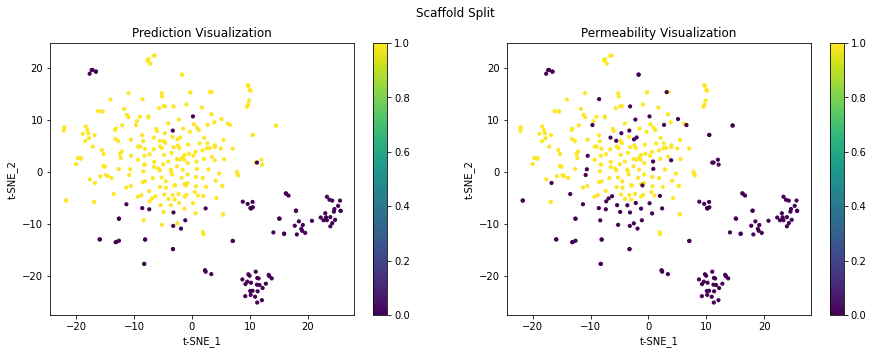

In [17]:
plot_split('Scaffold', y_pred_scaff, test_scaff.y, t_components_scaff)

## K-Fold anfd MCC Calcluations

In [18]:
def K_fold_MCC(dataset, h, split_name="Random Split", splitter=RandomSplitter()):
    
    split_data = splitter.k_fold_split(dataset, k=4)
    
    MCCs = []
    y_true = []
    h_predictions = []
    
    for data in split_data:
        h.fit(data[0].X, data[0].y)
        y_pred = h.predict(data[1].X)
        y_true.extend(list(data[1].y))
        h_predictions.extend(list(y_pred))
        mcc = matthews_corrcoef(data[1].y, y_pred)
        MCCs.append(mcc)
    
    print(split_name + " MCC Values:")
    
    for mcc in MCCs:
        print(mcc)
    print("Mean: " + str(np.mean(MCCs)))

    print("MCC value across full test data: " + str(matthews_corrcoef(y_true, h_predictions)))
    
    return MCCs

In [19]:
scaffoldsplitter = dc.splits.ScaffoldSplitter()
scaffold_split_mcc = K_fold_MCC(dataset, final_model, 'Scaffold Split', scaffoldsplitter)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Scaffold Split MCC Values:
0.7586646256039993
0.8361088119466458
0.47733816590699973
0.7657810101349732
Mean: 0.7094731533981545
MCC value across full test data: 0.7879888945626207


In [20]:
random_split_mcc = K_fold_MCC(dataset=dataset, h=final_model)

/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.8/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Random Split MCC Values:
0.8674521060047046
0.8538497022862972
0.858215794019498
0.893141589474305
Mean: 0.8681647979462012
MCC value across full test data: 0.8695811089834783


In [21]:
print("T Test P-value: " + str(ttest_ind(scaffold_split_mcc, random_split_mcc).pvalue))

T Test P-value: 0.09393880935135787


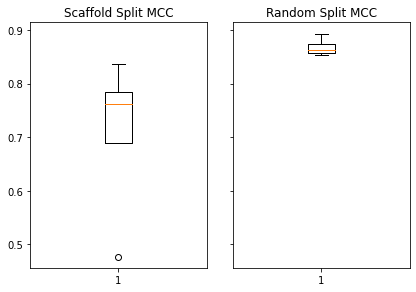

In [22]:
fig, ax = plt.subplots(1,2, sharey=True)
fig.tight_layout()

ax[0].boxplot(scaffold_split_mcc)
ax[0].title.set_text("Scaffold Split MCC")
ax[1].boxplot(random_split_mcc)
ax[1].title.set_text("Random Split MCC")